In [1]:
# ===============================================
# Data Cleaning
# ===============================================

# ====== Clean Imports ======
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Scikit-learn ---
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, confusion_matrix,
    classification_report, precision_recall_curve, fbeta_score,
    RocCurveDisplay, PrecisionRecallDisplay
)

# --- XGBoost ---
from xgboost import XGBClassifier


# ====== USER INPUTS ======
PATH_SPOT    = "Data/Daily_Spot_Prices_G10_FX_Pairs_Daily_2000_2025.csv"
PATH_IR_1M   = "Data/AT-21_FX_Forward_Points_1M_and_3M_Major_Pairs_Daily_2005_2025.csv"
PATH_RR      = "Data/AT-32_Risk_Reversal_Daily_2005_2025.csv"
PATH_VIX     = "Data/AT-33_Stress_Indicies_Daily_1999_2025.csv"   # or load your vix_df directly

WEEKLY_FREQ   = "W-FRI"
HORIZON_WEEKS = 4

# ====== LOAD DATA ======
def extract_series(df, date_col, value_col, new_name):
    out = df[[date_col, value_col]].copy()
    out.columns = ["Date", new_name]
    out["Date"] = pd.to_datetime(out["Date"])
    return out.set_index("Date").sort_index()

# --- Spot prices ---
spot_df = pd.read_csv(PATH_SPOT)
ser_EURUSD = extract_series(spot_df, "EURUSD - Date", "EURUSD -Last Price", "EURUSD")
ser_USDJPY = extract_series(spot_df, "USDJPY - Date", "USDJPY - Last Price", "USDJPY")
ser_GBPUSD = extract_series(spot_df, "GBPUSD - Date", "GBPUSD - Last Price", "GBPUSD")
ser_USDCAD = extract_series(spot_df, "USDCAD - Date", "USDCAD - Last Price", "USDCAD")
ser_AUDUSD = extract_series(spot_df, "AUDUSD - Date", "AUDUSD - Last Price", "AUDUSD")
spot = pd.concat([ser_EURUSD, ser_USDJPY, ser_GBPUSD, ser_USDCAD, ser_AUDUSD], axis=1)

# --- 1M rates ---
ir_df = pd.read_csv(PATH_IR_1M)
ser_EUR1M = extract_series(ir_df, "EUR1M Curncy - Date", "EUR1M Curncy - Last Price", "EUR")
ser_JPY1M = extract_series(ir_df, "JPY1M Curncy - Date", "JPY1M Curncy - Last Price", "JPY")
ser_GBP1M = extract_series(ir_df, "GBP1M Curncy - Date", "GBP1M Curncy - Last Price", "GBP")
ser_CAD1M = extract_series(ir_df, "CAD1M Curncy -  Date", "CAD1M Curncy - Last Price", "CAD")
rates = pd.concat([ser_EUR1M, ser_JPY1M, ser_GBP1M, ser_CAD1M], axis=1)

# --- Risk reversals ---
rr_df = pd.read_csv(PATH_RR)
rr_df["Date"] = pd.to_datetime(rr_df["Date"])
rr_df = rr_df.set_index("Date").sort_index()
rr_inputs = pd.DataFrame(index=rr_df.index)
rr_inputs["EUR"] = rr_df["EURUSD"]
rr_inputs["GBP"] = rr_df["GBPUSD"]
rr_inputs["AUD"] = rr_df["AUDUSD"]
rr_inputs["JPY"] = -rr_df["USDJPY"]
rr_inputs["CAD"] = -rr_df["USDCAD"]

# --- VIX ---
vix_df = pd.read_csv(PATH_VIX)
vix_df["Date"] = pd.to_datetime(vix_df["Date"])
vix_df = vix_df.set_index("Date").sort_index()
vix_w = vix_df.resample(WEEKLY_FREQ).last()
vix_w.rename(columns={"VIX Index  (R1)": "VIX"}, inplace=True)

# ====== RESAMPLE WEEKLY ======
spot_w  = spot.resample(WEEKLY_FREQ).last()
rates_w = rates.resample(WEEKLY_FREQ).last()
rr_w    = rr_inputs.resample(WEEKLY_FREQ).last()

# ====== COMPUTE WEEKLY RETURNS ======
logret = pd.DataFrame(index=spot_w.index)
logret["EUR"] = np.log(spot_w["EURUSD"]).diff()
logret["GBP"] = np.log(spot_w["GBPUSD"]).diff()
logret["AUD"] = np.log(spot_w["AUDUSD"]).diff()
logret["CAD"] = -np.log(spot_w["USDCAD"]).diff()
logret["JPY"] = -np.log(spot_w["USDJPY"]).diff()

# ====== SIMPLE CARRY PROXY (equal-weight 2 long, 2 short by 1M rates) ======
rankable = ["EUR","JPY","GBP","CAD"]
def make_weights_from_rates(r_row, n_long=2, n_short=2):
    s = r_row.dropna().sort_values(ascending=False)
    long = s.index[:n_long]; short = s.index[-n_short:]
    w = pd.Series(0.0, index=r_row.index)
    if len(long)>0:  w[long]  = +1/len(long)
    if len(short)>0: w[short] = -1/len(short)
    return w

rates_w_rank = rates_w[rankable].dropna(how="all")
month_ends = rates_w_rank.resample("ME").last().index
rates_m = rates_w_rank.reindex(month_ends, method="pad")
w_m = rates_m.apply(make_weights_from_rates, axis=1)
w_w = w_m.reindex(rates_w_rank.index).ffill().fillna(0)

carry_ret_w = (w_w * logret[rankable]).sum(axis=1)

# ====== COMPOSITE SKEW INDICATORS ======
def expanding_z(x, minp=52):
    mu = x.expanding(minp).mean(); sd = x.expanding(minp).std()
    return (x - mu)/sd

rr_z = rr_w.apply(expanding_z)
long_mask  = (w_w>0).astype(float); short_mask = (w_w<0).astype(float)
def bucket_avg(v,m): return (v*m).sum(axis=1)/m.sum(axis=1).replace(0,np.nan)
comp_skew = bucket_avg(rr_z, long_mask) - bucket_avg(rr_z, short_mask)
dfear = comp_skew.diff()

# ====== CONTROLS ======
mom_4w = carry_ret_w.rolling(4).sum()
vol_12w = carry_ret_w.rolling(12).std()
carry_strength = (w_w * rates_w).sum(axis=1)
controls_raw = pd.DataFrame({
    "mom_4w": mom_4w,
    "vol_12w": vol_12w,
    "carry_strength": carry_strength,
    "VIX": vix_w["VIX"].reindex(carry_ret_w.index)})

In [1]:
pip install RiskLabAI

     ------------------------------------ 168.7/168.7 KB 780.6 kB/s eta 0:00:00
     ---------------------------------------- 2.7/2.7 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 28.1/28.1 MB 1.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29429 sha256=47e222e5d9556d460b9f29fecb591f1122e8b99e81379db8359e6b5ffbd20311
  Stored in directory: c:\users\alexk\appdata\local\pip\cache\wheels\61\d8\66\8018676d483fa5edb5337a7a25ee8c029ac255be25f90f3cd5
Successfully built ta


In [2]:
# ===============================================
# MACHINE LEARNING CRASH CLASSIFICATION
# ===============================================

# --- Define 4-week forward return and crash target ---
fwd_ret_4w = carry_ret_w.shift(-1).rolling(HORIZON_WEEKS).sum()
crash_threshold = fwd_ret_4w.quantile(0.10)
crash_target = (fwd_ret_4w <= crash_threshold).astype(int).rename("CrashNextMonth")

# --- Build features ---
features = pd.DataFrame({
    "Skew_level": comp_skew,
    "Skew_change": dfear,
    "mom_4w": controls_raw["mom_4w"],
    "vol_12w": controls_raw["vol_12w"],
    "carry_strength": controls_raw["carry_strength"],
    "VIX": controls_raw["VIX"]
})

df_ml = pd.concat([features, crash_target], axis=1).dropna()
X = df_ml.drop(columns=["CrashNextMonth"])
y = df_ml["CrashNextMonth"]

print(f"Observations: {len(X)}, Crash share: {y.mean():.2%}")

Observations: 1042, Crash share: 12.86%


In [3]:
df_ml.head(3)

,Skew_level,Skew_change,mom_4w,vol_12w,carry_strength,VIX,CrashNextMonth
Date,,,,,,,
2005-10-07,0.692754,0.041942,0.011709,0.002920,29.735,14.59,0.0
2005-10-14,0.316647,-0.376107,0.003429,0.003964,27.925,14.87,0.0
2005-10-21,0.242270,-0.074377,0.005773,0.004006,27.950,16.13,0.0


In [4]:
# --- Train/test split (chronological) ---
split_idx = int(len(X)*0.7)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# --- Standardize features ---
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

AUC = 0.895
Confusion Matrix:
 [[252  47]
 [  3  11]]

Classification Report:
               precision    recall  f1-score   support

         0.0      0.988     0.843     0.910       299
         1.0      0.190     0.786     0.306        14

    accuracy                          0.840       313
   macro avg      0.589     0.814     0.608       313
weighted avg      0.953     0.840     0.883       313



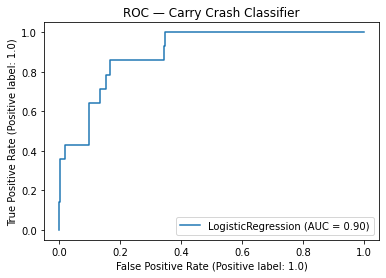

In [5]:
#===============================================
# --- Logistic regression classifier ---
#===============================================
clf = LogisticRegression(max_iter=1000, class_weight={0:1.0, 1:10.0})
clf.fit(X_train_s, y_train)

y_pred_prob = clf.predict_proba(X_test_s)[:,1]
y_pred = (y_pred_prob>=0.5).astype(int)

auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC = {auc:.3f}")
print("Confusion Matrix:\n", confusion_matrix(y_test,y_pred))
print("\nClassification Report:\n", classification_report(y_test,y_pred,digits=3))

RocCurveDisplay.from_estimator(clf, X_test_s, y_test)
plt.title("ROC — Carry Crash Classifier")
plt.show()

AUC = 0.864
Confusion Matrix:
 [[215  84]
 [  2  12]]

Classification Report:
               precision    recall  f1-score   support

         0.0      0.991     0.719     0.833       299
         1.0      0.125     0.857     0.218        14

    accuracy                          0.725       313
   macro avg      0.558     0.788     0.526       313
weighted avg      0.952     0.725     0.806       313



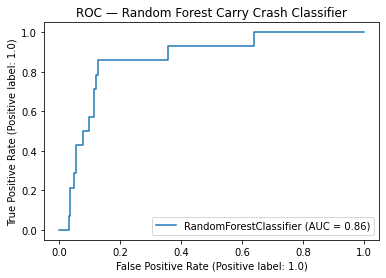

In [6]:
# ===============================================
# Random Forest Crash Classifier
# ===============================================

# --- Random Forest setup ---
rf = RandomForestClassifier(
    n_estimators=500,        # number of trees
    max_depth=5,             # limit depth to avoid overfitting
    min_samples_leaf=20,     # minimum samples per leaf
    class_weight={0:1, 1:10}, # emphasize crashes 5x more than non-crashes
    random_state=42,
    n_jobs=-1
)

# --- Fit model ---
rf.fit(X_train_s, y_train)

# --- Predict probabilities and labels ---
y_pred_prob = rf.predict_proba(X_test_s)[:, 1]
y_pred = (y_pred_prob >= 0.3).astype(int)

# --- Evaluate ---
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC = {auc:.3f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))

# --- ROC curve ---
RocCurveDisplay.from_estimator(rf, X_test_s, y_test)
plt.title("ROC — Random Forest Carry Crash Classifier")
plt.show()


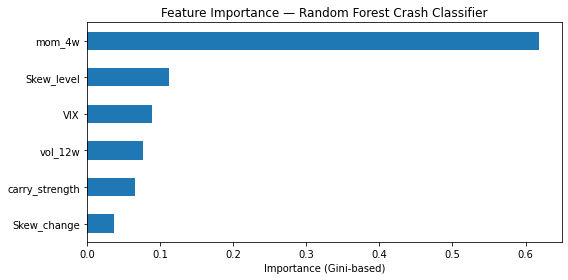


Top Feature Importances:
mom_4w            0.6184
Skew_level        0.1124
VIX               0.0892
vol_12w           0.0768
carry_strength    0.0661
Skew_change       0.0371
dtype: float64


In [7]:
# Get feature importances and map to column names
feat_imp = pd.Series(rf.feature_importances_, index=X_train.columns)

# Sort and display
feat_imp_sorted = feat_imp.sort_values(ascending=True)

plt.figure(figsize=(8, 4))
feat_imp_sorted.plot(kind="barh")
plt.title("Feature Importance — Random Forest Crash Classifier")
plt.xlabel("Importance (Gini-based)")
plt.tight_layout()
plt.show()

# Print ranked table
print("\nTop Feature Importances:")
print(feat_imp_sorted.sort_values(ascending=False).round(4))

AUC-ROC: 0.868   AUC-PR: 0.267
Confusion Matrix (τ=0.30):
 [[280  19]
 [  7   7]]

Classification Report (τ=0.30):
               precision    recall  f1-score   support

         0.0      0.976     0.936     0.956       299
         1.0      0.269     0.500     0.350        14

    accuracy                          0.917       313
   macro avg      0.622     0.718     0.653       313
weighted avg      0.944     0.917     0.929       313



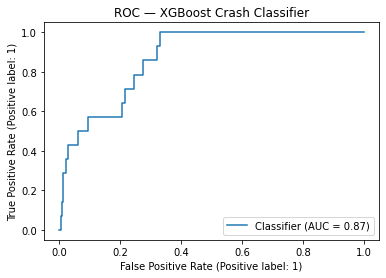

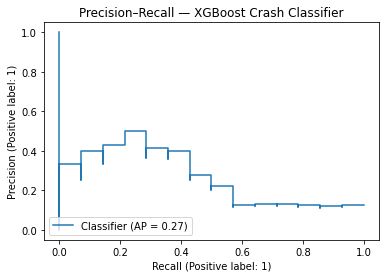


=== Feature Importances (Gain-based) ===
mom_4w            0.4559
vol_12w           0.1251
VIX               0.1139
Skew_level        0.1068
carry_strength    0.1014
Skew_change       0.0969


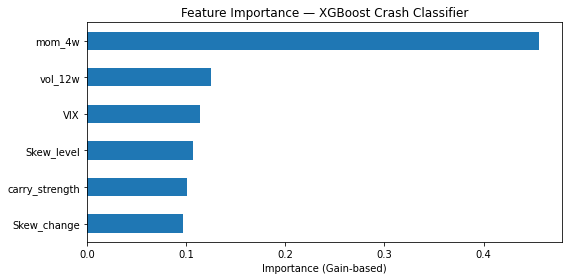

In [8]:
# ===============================================
# --- XGBoost model (no hyperparameter tuning) ---
# ===============================================
xgb = XGBClassifier(
    objective="binary:logistic",
    n_estimators=500,      # reasonable default
    max_depth=4,          # shallow to reduce overfit
    learning_rate=0.05,   # conservative
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    scale_pos_weight=10,  # weight class 1 ten times more than class 0
    n_jobs=-1,
    random_state=42,
    eval_metric="aucpr"   # evaluate with PR AUC (good for imbalance)
)

# Fit
xgb.fit(X_train, y_train)

# Predict probabilities and apply custom threshold
y_prob = xgb.predict_proba(X_test)[:, 1]
tau = 0.30
y_pred = (y_prob >= tau).astype(int)

# Metrics
auc_roc = roc_auc_score(y_test, y_prob)
auc_pr  = average_precision_score(y_test, y_prob)
cm      = confusion_matrix(y_test, y_pred)

print(f"AUC-ROC: {auc_roc:.3f}   AUC-PR: {auc_pr:.3f}")
print("Confusion Matrix (τ=0.30):\n", cm)
print("\nClassification Report (τ=0.30):\n",
      classification_report(y_test, y_pred, digits=3))

# ROC & PR curves
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC — XGBoost Crash Classifier"); plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_prob)
plt.title("Precision–Recall — XGBoost Crash Classifier"); plt.show()

# # Feature importance (gain-based)
# imp = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values()
# ax = imp.plot(kind="barh", figsize=(8,4))
# ax.set_title("Feature Importance — XGBoost"); plt.tight_layout(); plt.show()

# Get and sort importances
imp = pd.Series(xgb.feature_importances_, index=X_train.columns)
imp_sorted = imp.sort_values(ascending=False)

# Print numeric values
print("\n=== Feature Importances (Gain-based) ===")
print(imp_sorted.round(4).to_string())

# Plot horizontal bar chart
plt.figure(figsize=(8, 4))
imp_sorted.plot(kind="barh")
plt.title("Feature Importance — XGBoost Crash Classifier")
plt.xlabel("Importance (Gain-based)")
plt.gca().invert_yaxis()  # so most important appears at the top
plt.tight_layout()
plt.show()